In [1]:
import torch
import torch.nn as nn
from lib import config
import numpy as np
import os
import pandas as pd
import torch.optim as optim

from tqdm import tqdm
from PIL import Image, ImageFile
from lib import config
from torch.utils.data import Dataset, DataLoader
from lib.utils import (
    iou_width_height as iou,
    non_max_suppression as nms,
    plot_image,
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)

C:\Users\dokee\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## YOLO V3 Model

In [2]:
config_yolo = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias= not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x


class ScalePrediction(nn.Module):
    # False
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1
            ),
        )
        self.num_classes = num_classes

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )


class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config_yolo:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers

In [3]:
num_classes = 20
IMAGE_SIZE = 416
model = YOLOv3(num_classes=num_classes)
x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
out = model(x)
assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
assert model(x)[1].shape == (2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
print("Success!")

Success!


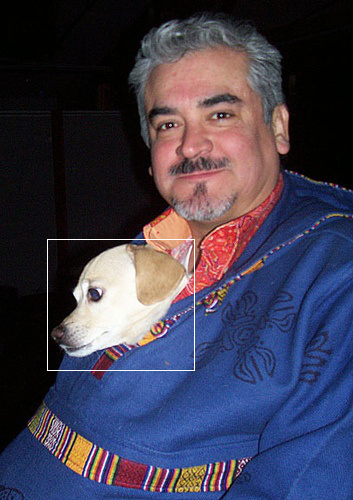

In [5]:
from PIL import Image, ImageDraw
label_path = "lib/datasets/idk.txt"
bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
bboxes
# x, y, width, height, class_label
image = Image.open("lib/datasets/idk.jpg")
real_x, real_y, real_w, real_h = bboxes[0][0] * image.size[0], bboxes[0][1] * image.size[1], bboxes[0][2] * image.size[0], bboxes[0][3] * image.size[1]
draw = ImageDraw.Draw(image)
draw.rectangle(((real_x - real_w / 2, real_y- real_h / 2), (real_x + real_w / 2, real_y + real_h / 2)))
image

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
class LISADataset(Dataset):
    def __init__(
        self,
        csv_file,
        name_file,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=47,
        transform=None,
    ):
        self.annotations = pd.read_csv("lib/datasets/train_val/" + csv_file)
        self.groups = self.annotations.groupby("Filename")
        self.names = np.load("lib/datasets/train_val/" + name_file).tolist()
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5
        keys = pd.read_csv("lib/datasets/train_val/key.csv")
        self.labs = keys["Label"].tolist()
        self.path = "lib/datasets/LISA/"

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        group_name = self.names[index]
        group = self.groups.get_group(group_name)
        bboxes = []
        for index, values in group.iterrows():
            lab = self.labs.index(values["Annotation tag"])
            image = Image.open(self.path+values["Filename"])
            width, height = image.size
            x1, x2, y1, y2 = values["Upper left corner X"] / width, values["Lower right corner X"] / width, values["Upper left corner Y"] / height, values["Lower right corner Y"] / height
            w, h = x2 - x1, y2-y1
            x, y = (x2 + x1) / 2, (y2 + y1) / 2
            # x, y, width, height, class_label
            bboxes.append([x,y,w,h,lab])
        image_path = self.path+group_name
        image = Image.open(image_path).convert("RGB")
        #image = image.resize((config.IMAGE_SIZE,config.IMAGE_SIZE))
        image = np.array(image)

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

        return image, tuple(targets)

In [5]:
def test():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = LISADataset(
        "train.csv",
        "train_list.npy",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    for x, y in loader:
        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)

In [4]:
def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

In [5]:
IMAGE_SIZE = 416
train_dataset = LISADataset("train.csv", "train_list.npy", S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
                           transform = config.train_transforms, anchors = config.ANCHORS)
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

In [6]:
val_dataset = LISADataset("val.csv", "val_list.npy", S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
                           transform = config.test_transforms, anchors = config.ANCHORS)
val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )


In [7]:
config.CHECKPOINT_FILE

'lib/models/checkpoint_test.pth.tar'

In [7]:
from lib.loss import YoloLoss
import warnings
from time import time
warnings.filterwarnings("ignore")
NUM_CLASSES = 47
DATASET = "lib/datasets/train_val"

model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
    )
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    )

scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

for epoch in range(0,config.NUM_EPOCHS):
    #plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    if epoch % 5 == 0:
        model.eval()
        check_class_accuracy(model, val_loader, threshold = config.CONF_THRESHOLD)
        print("Train Eval")
        pred_boxes, true_boxes = get_evaluation_bboxes(
            train_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
            box_format="midpoint",
        )
        maptrain = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print("Val Eval")
        pred_boxes, true_boxes = get_evaluation_bboxes(
            val_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
            box_format="midpoint",
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        model.train()
        print(f"Train mAP: {maptrain} Val mAP: {mapval}")
    print("Epoch",epoch)
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    

    if config.SAVE_MODEL:
       save_checkpoint(model, optimizer, filename="lib/models/checkpoint_final.pth.tar")

=> Loading checkpoint


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:45<00:00,  1.29it/s]


Class accuracy is: 97.522064%
No obj accuracy is: 99.976357%
Obj accuracy is: 83.537003%
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:23<00:00,  1.25s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.9612525701522827 Val mAP: 0.7702227234840393
Epoch 0


100%|███████████████████████████████████████████████████████████████████| 163/163 [02:46<00:00,  1.02s/it, loss=0.0805]


=> Saving checkpoint
Epoch 1


100%|███████████████████████████████████████████████████████████████████| 163/163 [02:47<00:00,  1.03s/it, loss=0.0697]


=> Saving checkpoint
Epoch 2


100%|███████████████████████████████████████████████████████████████████| 163/163 [02:46<00:00,  1.02s/it, loss=0.0682]


=> Saving checkpoint
Epoch 3


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:46<00:00,  1.02s/it, loss=0.07]


=> Saving checkpoint
Epoch 4


100%|███████████████████████████████████████████████████████████████████| 163/163 [02:45<00:00,  1.02s/it, loss=0.0621]


=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:44<00:00,  1.32it/s]


Class accuracy is: 97.589951%
No obj accuracy is: 99.980476%
Obj accuracy is: 80.091652%
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:24<00:00,  1.25s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.9780585169792175 Val mAP: 0.7525739669799805
Epoch 5


100%|███████████████████████████████████████████████████████████████████| 163/163 [02:46<00:00,  1.02s/it, loss=0.0638]


=> Saving checkpoint
Epoch 6


100%|███████████████████████████████████████████████████████████████████| 163/163 [02:46<00:00,  1.02s/it, loss=0.0624]


=> Saving checkpoint
Epoch 7


100%|███████████████████████████████████████████████████████████████████| 163/163 [03:22<00:00,  1.24s/it, loss=0.0808]


=> Saving checkpoint
Epoch 8


100%|███████████████████████████████████████████████████████████████████| 163/163 [02:43<00:00,  1.00s/it, loss=0.0682]


=> Saving checkpoint
Epoch 9


100%|███████████████████████████████████████████████████████████████████| 163/163 [02:41<00:00,  1.01it/s, loss=0.0684]


=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:44<00:00,  1.32it/s]


Class accuracy is: 97.589951%
No obj accuracy is: 99.981400%
Obj accuracy is: 78.343513%
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:19<00:00,  1.22s/it]


Val Eval


 63%|███████████████████████████████████████████████████▍                              | 37/59 [00:46<00:27,  1.26s/it]


KeyboardInterrupt: 

In [ ]:
from lib.loss import YoloLoss
import warnings
from time import time
warnings.filterwarnings("ignore")
NUM_CLASSES = 47
DATASET = "lib/datasets/train_val"

model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
    )
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    )

scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

for epoch in range(1,config.NUM_EPOCHS):
    #plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    if epoch % 5 == 0:
        print("Train Eval")
        pred_boxes, true_boxes = get_evaluation_bboxes(
            train_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        maptrain = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print("Val Eval")
        pred_boxes, true_boxes = get_evaluation_bboxes(
            val_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print(f"Train mAP: {maptrain} Val mAP: {mapval}")
    print("Epoch",epoch)
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    

    if config.SAVE_MODEL:
       save_checkpoint(model, optimizer, filename="lib/models/checkpoint_test2.pth.tar")

=> Loading checkpoint
Epoch 1


100%|████████████████████████████████████████████████████████████████████| 163/163 [03:02<00:00,  1.12s/it, loss=0.392]


=> Saving checkpoint
Epoch 2


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.387]


=> Saving checkpoint
Epoch 3


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.09s/it, loss=0.42]


=> Saving checkpoint
Epoch 4


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.391]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:35<00:00,  1.32s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.8898012638092041 Val mAP: 0.7175412774085999
Epoch 5


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.389]


=> Saving checkpoint
Epoch 6


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.384]


=> Saving checkpoint
Epoch 7


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.448]


=> Saving checkpoint
Epoch 8


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.425]


=> Saving checkpoint
Epoch 9


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.09s/it, loss=0.423]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:36<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.8580440878868103 Val mAP: 0.7141653299331665
Epoch 10


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.09s/it, loss=0.412]


=> Saving checkpoint
Epoch 11


100%|████████████████████████████████████████████████████████████████████| 163/163 [03:02<00:00,  1.12s/it, loss=0.404]


=> Saving checkpoint
Epoch 12


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.09s/it, loss=0.41]


=> Saving checkpoint
Epoch 13


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.412]


=> Saving checkpoint
Epoch 14


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.10s/it, loss=0.392]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:17<00:00,  1.31s/it]


Train mAP: 0.8803121447563171 Val mAP: 0.7238935828208923
Epoch 15


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.09s/it, loss=0.375]


=> Saving checkpoint
Epoch 16


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.404]


=> Saving checkpoint
Epoch 17


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.419]


=> Saving checkpoint
Epoch 18


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.556]


=> Saving checkpoint
Epoch 19


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.441]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:36<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.8841947317123413 Val mAP: 0.7279807329177856
Epoch 20


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.441]


=> Saving checkpoint
Epoch 21


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.422]


=> Saving checkpoint
Epoch 22


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.382]


=> Saving checkpoint
Epoch 23


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.361]


=> Saving checkpoint
Epoch 24


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.371]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:36<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.8772028088569641 Val mAP: 0.7488505840301514
Epoch 25


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.358]


=> Saving checkpoint
Epoch 26


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.351]


=> Saving checkpoint
Epoch 27


100%|████████████████████████████████████████████████████████████████████| 163/163 [03:00<00:00,  1.11s/it, loss=0.373]


=> Saving checkpoint
Epoch 28


100%|████████████████████████████████████████████████████████████████████| 163/163 [03:12<00:00,  1.18s/it, loss=0.388]


=> Saving checkpoint
Epoch 29


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:59<00:00,  1.10s/it, loss=0.469]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:40<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.27s/it]


Train mAP: 0.8965647220611572 Val mAP: 0.7516949772834778
Epoch 30


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:59<00:00,  1.10s/it, loss=0.394]


=> Saving checkpoint
Epoch 31


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.10s/it, loss=0.382]


=> Saving checkpoint
Epoch 32


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.09s/it, loss=0.379]


=> Saving checkpoint
Epoch 33


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.401]


=> Saving checkpoint
Epoch 34


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=nan]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:40<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.8859339952468872 Val mAP: 0.7604020833969116
Epoch 35


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.389]


=> Saving checkpoint
Epoch 36


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.38]


=> Saving checkpoint
Epoch 37


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.386]


=> Saving checkpoint
Epoch 38


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.386]


=> Saving checkpoint
Epoch 39


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.382]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:39<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.27s/it]


Train mAP: 0.8882209062576294 Val mAP: 0.722355306148529
Epoch 40


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.09s/it, loss=0.366]


=> Saving checkpoint
Epoch 41


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.353]


=> Saving checkpoint
Epoch 42


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.10s/it, loss=0.352]


=> Saving checkpoint
Epoch 43


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.09s/it, loss=0.37]


=> Saving checkpoint
Epoch 44


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:58<00:00,  1.09s/it, loss=0.376]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:40<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.8862892985343933 Val mAP: 0.7305096983909607
Epoch 45


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.368]


=> Saving checkpoint
Epoch 46


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.374]


=> Saving checkpoint
Epoch 47


100%|████████████████████████████████████████████████████████████████████| 163/163 [03:00<00:00,  1.10s/it, loss=0.352]


=> Saving checkpoint
Epoch 48


100%|████████████████████████████████████████████████████████████████████| 163/163 [03:13<00:00,  1.19s/it, loss=0.364]


=> Saving checkpoint
Epoch 49


100%|████████████████████████████████████████████████████████████████████| 163/163 [03:02<00:00,  1.12s/it, loss=0.368]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:39<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.8993211388587952 Val mAP: 0.7329853773117065
Epoch 50


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:57<00:00,  1.09s/it, loss=0.362]


=> Saving checkpoint
Epoch 51


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.359]


=> Saving checkpoint
Epoch 52


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.344]


=> Saving checkpoint
Epoch 53


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.346]


=> Saving checkpoint
Epoch 54


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.356]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:36<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.9154745936393738 Val mAP: 0.754727840423584
Epoch 55


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.37]


=> Saving checkpoint
Epoch 56


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.351]


=> Saving checkpoint
Epoch 57


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.419]


=> Saving checkpoint
Epoch 58


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.386]


=> Saving checkpoint
Epoch 59


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.388]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:35<00:00,  1.32s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.8693948984146118 Val mAP: 0.7486490607261658
Epoch 60


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.349]


=> Saving checkpoint
Epoch 61


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.345]


=> Saving checkpoint
Epoch 62


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.335]


=> Saving checkpoint
Epoch 63


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.347]


=> Saving checkpoint
Epoch 64


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.344]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:35<00:00,  1.32s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.9050947427749634 Val mAP: 0.7435616254806519
Epoch 65


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.376]


=> Saving checkpoint
Epoch 66


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.348]


=> Saving checkpoint
Epoch 67


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.38]


=> Saving checkpoint
Epoch 68


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.352]


=> Saving checkpoint
Epoch 69


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.361]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:35<00:00,  1.32s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.9137426614761353 Val mAP: 0.7613105773925781
Epoch 70


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.387]


=> Saving checkpoint
Epoch 71


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.402]


=> Saving checkpoint
Epoch 72


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.342]


=> Saving checkpoint
Epoch 73


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.323]


=> Saving checkpoint
Epoch 74


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.433]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:36<00:00,  1.33s/it]


Val Eval


 49%|████████████████████████████████████████▎                                         | 29/59 [00:36<00:38,  1.27s/it]

In [7]:
from lib.loss import YoloLoss
import warnings
from time import time
warnings.filterwarnings("ignore")
NUM_CLASSES = 47
DATASET = "lib/datasets/train_val"

model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
    )
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    )

scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

for epoch in range(1,config.NUM_EPOCHS):
    #plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    if epoch % 5 == 0:
        print("Train Eval")
        pred_boxes, true_boxes = get_evaluation_bboxes(
            train_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        maptrain = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print("Val Eval")
        pred_boxes, true_boxes = get_evaluation_bboxes(
            val_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print(f"Train mAP: {maptrain} Val mAP: {mapval}")
    print("Epoch",epoch)
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    

    if config.SAVE_MODEL:
       save_checkpoint(model, optimizer, filename="lib/models/checkpoint_test1.pth.tar")

=> Loading checkpoint
Epoch 1


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:02<00:00,  1.12s/it, loss=1.27]


=> Saving checkpoint
Epoch 2


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.24]


=> Saving checkpoint
Epoch 3


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=1.31]


=> Saving checkpoint
Epoch 4


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=1.21]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:35<00:00,  1.32s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.4834137260913849 Val mAP: 0.35664358735084534
Epoch 5


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.18]


=> Saving checkpoint
Epoch 6


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=1.21]


=> Saving checkpoint
Epoch 7


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=1.23]


=> Saving checkpoint
Epoch 8


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=1.24]


=> Saving checkpoint
Epoch 9


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=1.25]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:39<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.4913210868835449 Val mAP: 0.37935125827789307
Epoch 10


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.2]


=> Saving checkpoint
Epoch 11


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=1.29]


=> Saving checkpoint
Epoch 12


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=1.15]


=> Saving checkpoint
Epoch 13


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=1.1]


=> Saving checkpoint
Epoch 14


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=1.08]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:37<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.49599960446357727 Val mAP: 0.3774054944515228
Epoch 15


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=1.09]


=> Saving checkpoint
Epoch 16


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=1.09]


=> Saving checkpoint
Epoch 17


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.05]


=> Saving checkpoint
Epoch 18


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.07]


=> Saving checkpoint
Epoch 19


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.07]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:40<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.27s/it]


Train mAP: 0.5221444368362427 Val mAP: 0.44364747405052185
Epoch 20


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.02]


=> Saving checkpoint
Epoch 21


100%|████████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=1]


=> Saving checkpoint
Epoch 22


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.03]


=> Saving checkpoint
Epoch 23


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=1.03]


=> Saving checkpoint
Epoch 24


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=1.1]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.5337319374084473 Val mAP: 0.4215613603591919
Epoch 25


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=1.02]


=> Saving checkpoint
Epoch 26


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.955]


=> Saving checkpoint
Epoch 27


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.966]


=> Saving checkpoint
Epoch 28


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.97]


=> Saving checkpoint
Epoch 29


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.02]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:36<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.6088793873786926 Val mAP: 0.4661499857902527
Epoch 30


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.943]


=> Saving checkpoint
Epoch 31


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.987]


=> Saving checkpoint
Epoch 32


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.5]


=> Saving checkpoint
Epoch 33


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.989]


=> Saving checkpoint
Epoch 34


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.949]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:37<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.27s/it]


Train mAP: 0.5900326371192932 Val mAP: 0.45967891812324524
Epoch 35


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.911]


=> Saving checkpoint
Epoch 36


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.92]


=> Saving checkpoint
Epoch 37


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.955]


=> Saving checkpoint
Epoch 38


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.888]


=> Saving checkpoint
Epoch 39


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.921]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:39<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.28s/it]


Train mAP: 0.559434175491333 Val mAP: 0.46107712388038635
Epoch 40


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.904]


=> Saving checkpoint
Epoch 41


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.902]


=> Saving checkpoint
Epoch 42


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.839]


=> Saving checkpoint
Epoch 43


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.846]


=> Saving checkpoint
Epoch 44


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.851]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.27s/it]


Train mAP: 0.6410830616950989 Val mAP: 0.48396483063697815
Epoch 45


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.824]


=> Saving checkpoint
Epoch 46


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.808]


=> Saving checkpoint
Epoch 47


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=1.03]


=> Saving checkpoint
Epoch 48


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.885]


=> Saving checkpoint
Epoch 49


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.955]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:37<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.6409406065940857 Val mAP: 0.4934540092945099
Epoch 50


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.88]


=> Saving checkpoint
Epoch 51


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.846]


=> Saving checkpoint
Epoch 52


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.81]


=> Saving checkpoint
Epoch 53


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.8]


=> Saving checkpoint
Epoch 54


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.78]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.27s/it]


Train mAP: 0.6733319163322449 Val mAP: 0.5249097347259521
Epoch 55


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.801]


=> Saving checkpoint
Epoch 56


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.789]


=> Saving checkpoint
Epoch 57


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.756]


=> Saving checkpoint
Epoch 58


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.753]


=> Saving checkpoint
Epoch 59


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.746]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:37<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.6650115847587585 Val mAP: 0.5437481999397278
Epoch 60


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.778]


=> Saving checkpoint
Epoch 61


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.845]


=> Saving checkpoint
Epoch 62


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.745]


=> Saving checkpoint
Epoch 63


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.735]


=> Saving checkpoint
Epoch 64


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.764]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.6818198561668396 Val mAP: 0.5154221057891846
Epoch 65


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.729]


=> Saving checkpoint
Epoch 66


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.09s/it, loss=0.775]


=> Saving checkpoint
Epoch 67


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.756]


=> Saving checkpoint
Epoch 68


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.919]


=> Saving checkpoint
Epoch 69


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.755]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.7188002467155457 Val mAP: 0.5735399127006531
Epoch 70


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.709]


=> Saving checkpoint
Epoch 71


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.699]


=> Saving checkpoint
Epoch 72


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.698]


=> Saving checkpoint
Epoch 73


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.77]


=> Saving checkpoint
Epoch 74


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.715]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:37<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.7201933264732361 Val mAP: 0.5456165671348572
Epoch 75


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.687]


=> Saving checkpoint
Epoch 76


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.689]


=> Saving checkpoint
Epoch 77


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.731]


=> Saving checkpoint
Epoch 78


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.671]


=> Saving checkpoint
Epoch 79


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.684]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:36<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.7543258666992188 Val mAP: 0.5675420761108398
Epoch 80


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.764]


=> Saving checkpoint
Epoch 81


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=0.675]


=> Saving checkpoint
Epoch 82


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.667]


=> Saving checkpoint
Epoch 83


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.681]


=> Saving checkpoint
Epoch 84


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.665]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:37<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.7674427628517151 Val mAP: 0.6665188670158386
Epoch 85


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.642]


=> Saving checkpoint
Epoch 86


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.641]


=> Saving checkpoint
Epoch 87


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.796]


=> Saving checkpoint
Epoch 88


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.693]


=> Saving checkpoint
Epoch 89


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.648]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:37<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.27s/it]


Train mAP: 0.7257645726203918 Val mAP: 0.5757334232330322
Epoch 90


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:56<00:00,  1.08s/it, loss=0.795]


=> Saving checkpoint
Epoch 91


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.693]


=> Saving checkpoint
Epoch 92


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.697]


=> Saving checkpoint
Epoch 93


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.669]


=> Saving checkpoint
Epoch 94


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.641]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:36<00:00,  1.33s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.8039876222610474 Val mAP: 0.6410316228866577
Epoch 95


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.614]


=> Saving checkpoint
Epoch 96


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.595]


=> Saving checkpoint
Epoch 97


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.609]


=> Saving checkpoint
Epoch 98


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.07s/it, loss=0.605]


=> Saving checkpoint
Epoch 99


100%|████████████████████████████████████████████████████████████████████| 163/163 [02:55<00:00,  1.08s/it, loss=0.588]


=> Saving checkpoint


In [8]:
from lib.loss import YoloLoss
import warnings
from time import time
warnings.filterwarnings("ignore")
NUM_CLASSES = 47
DATASET = "lib/datasets/train_val"

model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
    )
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    )

scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

for epoch in range(1,config.NUM_EPOCHS):
    #plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    if epoch % 5 == 0:
        print("Train Eval")
        pred_boxes, true_boxes = get_evaluation_bboxes(
            train_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        maptrain = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print("Val Eval")
        pred_boxes, true_boxes = get_evaluation_bboxes(
            val_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print(f"Train mAP: {maptrain} Val mAP: {mapval}")
    print("Epoch",epoch)
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    

    if config.SAVE_MODEL:
       save_checkpoint(model, optimizer, filename="lib/models/checkpoint_test1.pth.tar")

#     print(f"Currently epoch {epoch}")
#     print("Train")
#     check_class_accuracy(model, train_loader, threshold=config.CONF_THRESHOLD)
#     print("val")
#     check_class_accuracy(model, val_loader, threshold=config.CONF_THRESHOLD)

#     if epoch > 0 and epoch % 3 == 0:
#         check_class_accuracy(model, val_loader, threshold=config.CONF_THRESHOLD)
#         model.train()

=> Loading checkpoint
Epoch 1


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:12<00:00,  1.18s/it, loss=13.6]


=> Saving checkpoint
Epoch 2


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:08<00:00,  1.16s/it, loss=13.2]


=> Saving checkpoint
Epoch 3


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:04<00:00,  1.13s/it, loss=12.8]


=> Saving checkpoint
Epoch 4


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:05<00:00,  1.14s/it, loss=12.5]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:42<00:00,  1.36s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.27s/it]


Train mAP: 0.0 Val mAP: 0.0
Epoch 5


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:04<00:00,  1.13s/it, loss=12.1]


=> Saving checkpoint
Epoch 6


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:02<00:00,  1.12s/it, loss=11.9]


=> Saving checkpoint
Epoch 7


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:03<00:00,  1.12s/it, loss=11.6]


=> Saving checkpoint
Epoch 8


100%|█████████████████████████████████████████████████████████████████████| 163/163 [03:03<00:00,  1.12s/it, loss=11.3]


=> Saving checkpoint
Epoch 9


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=11.1]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:28<00:00,  1.28s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:12<00:00,  1.23s/it]


Train mAP: 0.0 Val mAP: 0.0
Epoch 10


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=10.9]


=> Saving checkpoint
Epoch 11


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=10.7]


=> Saving checkpoint
Epoch 12


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=10.4]


=> Saving checkpoint
Epoch 13


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=10.2]


=> Saving checkpoint
Epoch 14


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=9.9]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:29<00:00,  1.29s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:11<00:00,  1.21s/it]


Train mAP: 0.0003432802332099527 Val mAP: 3.5461758670862764e-05
Epoch 15


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=9.65]


=> Saving checkpoint
Epoch 16


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=9.41]


=> Saving checkpoint
Epoch 17


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=9.11]


=> Saving checkpoint
Epoch 18


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=8.9]


=> Saving checkpoint
Epoch 19


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=8.64]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:32<00:00,  1.30s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:12<00:00,  1.22s/it]


Train mAP: 0.0024654550943523645 Val mAP: 0.004240209236741066
Epoch 20


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=8.32]


=> Saving checkpoint
Epoch 21


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=8.01]


=> Saving checkpoint
Epoch 22


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=nan]


=> Saving checkpoint
Epoch 23


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=7.56]


=> Saving checkpoint
Epoch 24


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=7.26]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:33<00:00,  1.31s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:12<00:00,  1.23s/it]


Train mAP: 0.010801288299262524 Val mAP: 0.021041665226221085
Epoch 25


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=7.02]


=> Saving checkpoint
Epoch 26


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=6.81]


=> Saving checkpoint
Epoch 27


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=6.51]


=> Saving checkpoint
Epoch 28


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=6.3]


=> Saving checkpoint
Epoch 29


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=6.21]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:31<00:00,  1.30s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:11<00:00,  1.22s/it]


Train mAP: 0.025436731055378914 Val mAP: 0.023617485538125038
Epoch 30


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=5.86]


=> Saving checkpoint
Epoch 31


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=5.62]


=> Saving checkpoint
Epoch 32


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=5.49]


=> Saving checkpoint
Epoch 33


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=5.43]


=> Saving checkpoint
Epoch 34


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=5.2]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.044566936790943146 Val mAP: 0.0329001247882843
Epoch 35


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=5.01]


=> Saving checkpoint
Epoch 36


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=5.06]


=> Saving checkpoint
Epoch 37


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=4.77]


=> Saving checkpoint
Epoch 38


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=4.6]


=> Saving checkpoint
Epoch 39


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=4.43]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.05967007949948311 Val mAP: 0.05353628844022751
Epoch 40


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=4.17]


=> Saving checkpoint
Epoch 41


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=4.08]


=> Saving checkpoint
Epoch 42


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=3.93]


=> Saving checkpoint
Epoch 43


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=3.81]


=> Saving checkpoint
Epoch 44


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=3.65]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:42<00:00,  1.36s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.09245703369379044 Val mAP: 0.0920526534318924
Epoch 45


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=3.56]


=> Saving checkpoint
Epoch 46


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=3.62]


=> Saving checkpoint
Epoch 47


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=3.38]


=> Saving checkpoint
Epoch 48


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=3.32]


=> Saving checkpoint
Epoch 49


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=3.2]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.12313999235630035 Val mAP: 0.10377351939678192
Epoch 50


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=3.09]


=> Saving checkpoint
Epoch 51


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=3.07]


=> Saving checkpoint
Epoch 52


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.99]


=> Saving checkpoint
Epoch 53


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.89]


=> Saving checkpoint
Epoch 54


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.76]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:40<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.1444292962551117 Val mAP: 0.10919778794050217
Epoch 55


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.77]


=> Saving checkpoint
Epoch 56


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.71]


=> Saving checkpoint
Epoch 57


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.65]


=> Saving checkpoint
Epoch 58


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.53]


=> Saving checkpoint
Epoch 59


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.42]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:39<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.1778654158115387 Val mAP: 0.10774684697389603
Epoch 60


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.42]


=> Saving checkpoint
Epoch 61


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.39]


=> Saving checkpoint
Epoch 62


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.36]


=> Saving checkpoint
Epoch 63


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.3]


=> Saving checkpoint
Epoch 64


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.2]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:40<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.19400742650032043 Val mAP: 0.17222726345062256
Epoch 65


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=2.19]


=> Saving checkpoint
Epoch 66


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.11]


=> Saving checkpoint
Epoch 67


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=2.08]


=> Saving checkpoint
Epoch 68


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=2.02]


=> Saving checkpoint
Epoch 69


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=2.07]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:44<00:00,  1.38s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.27s/it]


Train mAP: 0.24832803010940552 Val mAP: 0.16700336337089539
Epoch 70


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=2.07]


=> Saving checkpoint
Epoch 71


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.96]


=> Saving checkpoint
Epoch 72


100%|████████████████████████████████████████████████████████████████████████| 163/163 [02:54<00:00,  1.07s/it, loss=2]


=> Saving checkpoint
Epoch 73


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.93]


=> Saving checkpoint
Epoch 74


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=1.88]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.24s/it]


Train mAP: 0.28856027126312256 Val mAP: 0.2088892161846161
Epoch 75


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.79]


=> Saving checkpoint
Epoch 76


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.72]


=> Saving checkpoint
Epoch 77


100%|██████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.9]


=> Saving checkpoint
Epoch 78


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.75]


=> Saving checkpoint
Epoch 79


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.81]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:40<00:00,  1.35s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.2813819646835327 Val mAP: 0.25682803988456726
Epoch 80


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=1.71]


=> Saving checkpoint
Epoch 81


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.64]


=> Saving checkpoint
Epoch 82


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.64]


=> Saving checkpoint
Epoch 83


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.58]


=> Saving checkpoint
Epoch 84


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.53]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:43<00:00,  1.37s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.3672419488430023 Val mAP: 0.2468772828578949
Epoch 85


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=1.61]


=> Saving checkpoint
Epoch 86


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.66]


=> Saving checkpoint
Epoch 87


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.53]


=> Saving checkpoint
Epoch 88


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=1.47]


=> Saving checkpoint
Epoch 89


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.62]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:38<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:14<00:00,  1.26s/it]


Train mAP: 0.3908138573169708 Val mAP: 0.3036740720272064
Epoch 90


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.56]


=> Saving checkpoint
Epoch 91


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.42]


=> Saving checkpoint
Epoch 92


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=1.39]


=> Saving checkpoint
Epoch 93


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.36]


=> Saving checkpoint
Epoch 94


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.41]


=> Saving checkpoint
Train Eval


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:37<00:00,  1.34s/it]


Val Eval


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.25s/it]


Train mAP: 0.3911594748497009 Val mAP: 0.2827354669570923
Epoch 95


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=1.37]


=> Saving checkpoint
Epoch 96


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=1.39]


=> Saving checkpoint
Epoch 97


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.06s/it, loss=1.31]


=> Saving checkpoint
Epoch 98


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.44]


=> Saving checkpoint
Epoch 99


100%|█████████████████████████████████████████████████████████████████████| 163/163 [02:53<00:00,  1.07s/it, loss=1.36]


=> Saving checkpoint


In [9]:
config.CHECKPOINT_FILE

'lib/models/checkpoint1.pth.tar'